<a href="https://colab.research.google.com/github/giseldo/neolegibilitymodel/blob/main/7764.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVR
import textstat
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [3]:
name = "7764"
filename = "../data/neo/csv/{}.csv".format(name)
df_full = pd.read_csv(filename)
df_full.head()

,issuekey,created,title,description,storypoints
0,29688087,2020-01-17 00:50:48.022,Update templates for website merge requests,Relates to &232 and #6109 \r\n\r\nGoals:\r\n\r...,1
1,29682716,2020-01-16 19:21:38.595,Make sure that we Capture Advanced Search in o...,This was raised in the PM & Engineering meetin...,1
2,29644971,2020-01-15 21:17:03.379,Propose new IA for Brand and Digital Handbook,## Goals\r\nPropose new IA for Brand and Digit...,1
3,29494181,2020-01-10 19:20:50.351,Cache `node_modules` for www-gitlab-com pipelines,# UPDATE NOTE: This MR will not be implemented...,1
4,29437529,2020-01-09 10:26:51.545,Disable all remaining unnecessary jobs in pipe...,Similar to https://gitlab.com/gitlab-com/www-g...,1


Esse conjunto de dados tem 355 User Stories.

In [4]:
df_full["context"] = df_full["title"] + df_full["description"]
df_full = df_full.drop(['created', 'issuekey', 'title', 'description'], axis=1)
df_full['context'] = df_full['context'].astype(str)
df_full.head()

,storypoints,context
0,1,Update templates for website merge requestsRel...
1,1,Make sure that we Capture Advanced Search in o...
2,1,Propose new IA for Brand and Digital Handbook#...
3,1,Cache `node_modules` for www-gitlab-com pipeli...
4,1,Disable all remaining unnecessary jobs in pipe...


Foi apagado as colunas created, issuekey, title e description.

In [5]:
df_full["storypoints"].describe()

count    355.000000
mean       2.732394
std        7.186298
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max      128.000000
Name: storypoints, dtype: float64

Text(0, 0.5, 'Contagem de vezes dos Story Points')

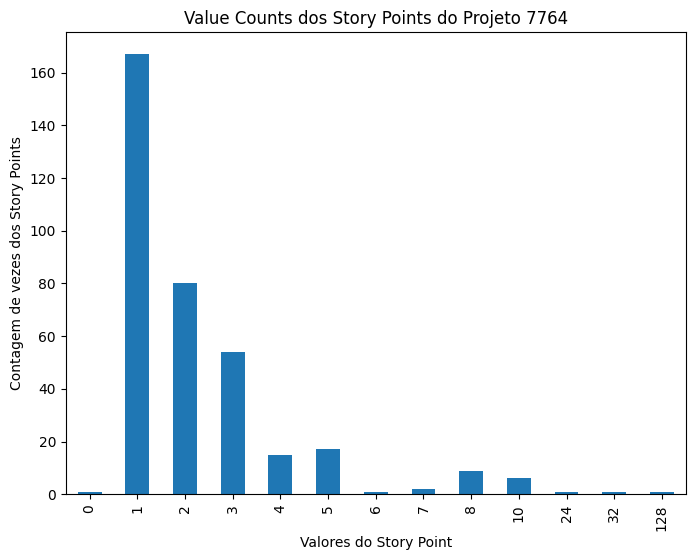

In [6]:
value_count = df_full["storypoints"].value_counts().sort_index()
plt.figure(figsize=(8,6))
value_count.plot(kind='bar')
plt.title("Value Counts dos Story Points do Projeto 7764")
plt.xlabel("Valores do Story Point")
plt.ylabel("Contagem de vezes dos Story Points")

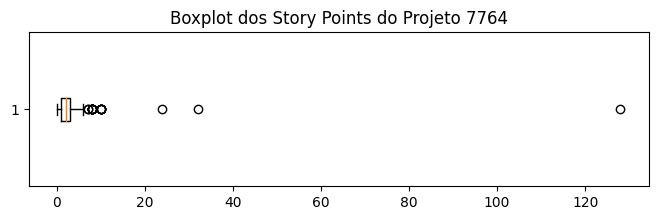

In [9]:
plt.figure(figsize=(8,2))
plt.boxplot(df_full['storypoints'], vert=False)
plt.title('Boxplot dos Story Points do Projeto 7764')
plt.show()

In [11]:
# remover outliers
mean = df_full["storypoints"].mean()
std_dev = df_full["storypoints"].std()
outlier_cutoff = 2 * std_dev
df_clean = df_full[(df_full["storypoints"] >= mean - outlier_cutoff) & (df_full["storypoints"] <= mean + outlier_cutoff)]
df_clean.head()

,storypoints,context
0,1,Update templates for website merge requestsRel...
1,1,Make sure that we Capture Advanced Search in o...
2,1,Propose new IA for Brand and Digital Handbook#...
3,1,Cache `node_modules` for www-gitlab-com pipeli...
4,1,Disable all remaining unnecessary jobs in pipe...


Text(0.5, 1.0, 'Boxplot dos Story Points do Projeto 7764 depois da remoção dos outliers')

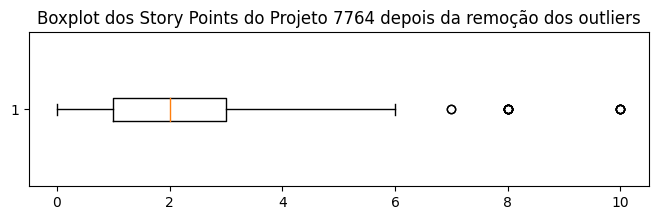

In [12]:
plt.figure(figsize=(8,2))
plt.boxplot(df_clean['storypoints'], vert=False)
plt.title('Boxplot dos Story Points do Projeto 7764 depois da remoção dos outliers')

Boxplot depois da remoção dos outliers

Text(0, 0.5, 'Contagem de vezes')

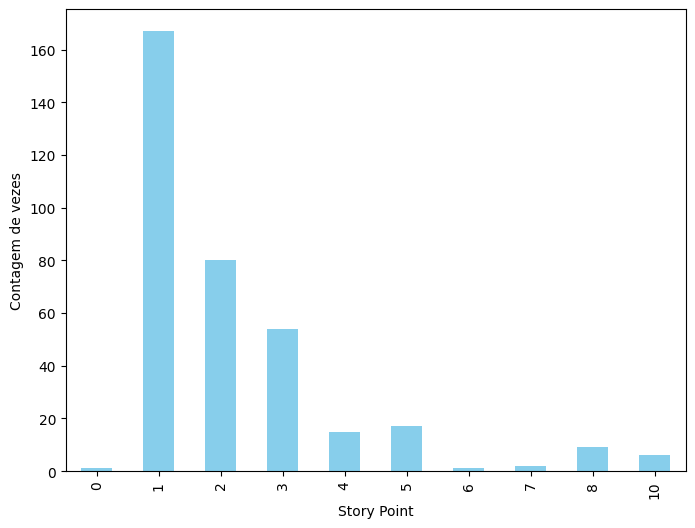

In [13]:
value_count = df_clean["storypoints"].value_counts().sort_index()
plt.figure(figsize=(8,6))
value_count.plot(kind='bar', color='skyblue')
plt.ylabel("Value Counts dos Story Points depois da remoção dos outliers do Projeto 7764")
plt.xlabel("Story Point")
plt.ylabel("Contagem de vezes")

In [35]:
storypoint_medio = df_clean["storypoints"].mean()
storypoint_medio

2.2329545454545454

Em média, nesse conjunto de dados, o Story Point Médio é de 2.23

In [144]:
def mean_absolute_error(y_true, y_pred):
  """
  Calcula o Mean Absolute Error (MAE), entre os valores verdadeiros (y_true) e os valores previstos (y_pred)

  Args:
    y_true: Uma lista ou array Numpy dos valores verdadeiros.
    y_pred: Uma lista ou array NumPy dos valores previstos.

  Returns:
    mae: O Mean Absolute Error entre y_true e y_pred
  """
  if len(y_true) != len(y_pred):
    raise ValueError("Os tamanhos de y_true e y_pred devem ser iguais")
  absolute_Errors =[abs(true-pred) for true, pred in zip(y_true, y_pred)]
  mae = sum(absolute_Errors) / len(y_true)
  return mae

In [145]:
lista_y_pred = [storypoint_medio] * len(df_clean)
mean_absolute_error( df_clean["storypoints"], lista_y_pred)

1.288481404958678

O MAE de todos os dados é 1.28

Se utilizarmos todo o conjunto de dados o erro médio absoluto quando utilizamos o Story Point médio como preditor (para todas as instâncias) é de 1.28.
Ou seja, se sempre atribuirmos um valor de 2.23 (o Story Point Médio) a uma nova User Story ele estará em média errado 1.97 Story Point.

Vamos separa entre treino e teste para realizar uma comparação com o modelo predito, somente com teste.

In [146]:
# separação treino e teste
percent_treino = 0.7
num_linhas_treino = int(len(df_clean) * percent_treino)

dados_treino = df_clean.iloc[:num_linhas_treino]
dados_teste = df_clean.iloc[num_linhas_treino:]

In [147]:
lista_y_pred = [storypoint_medio] * len(dados_treino)
mean_absolute_error(dados_treino["storypoints"], lista_y_pred)

1.2697246858832216

O MAE do treino é de 1.26

In [148]:
lista_y_pred = [storypoint_medio] * len(dados_teste)
mae_media_sp = mean_absolute_error(dados_teste["storypoints"], lista_y_pred)

df_results = pd.DataFrame(data=[['mae_media_sp', mae_media_sp]], columns=["modelo", "MAE Teste"])
df_results

,modelo,MAE Teste
0,mae_media_sp,1.332011


O MAE do teste é 1.35, portanto um preditor deve ao menos ser melhor do que o uso do Story Point Médio.

Text(0, 0.5, 'Contagem de vezes dos dados de treino')

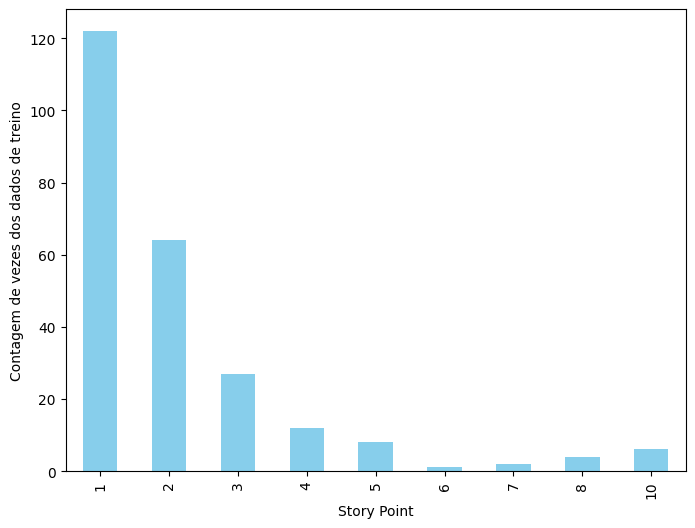

In [149]:
value_count = dados_treino["storypoints"].value_counts().sort_index()
plt.figure(figsize=(8,6))
value_count.plot(kind='bar', color='skyblue')
plt.ylabel("Value Counts dos Story Points")
plt.xlabel("Story Point")
plt.ylabel("Contagem de vezes dos dados de treino")

Text(0, 0.5, 'Contagem de vezes dos dados de teste')

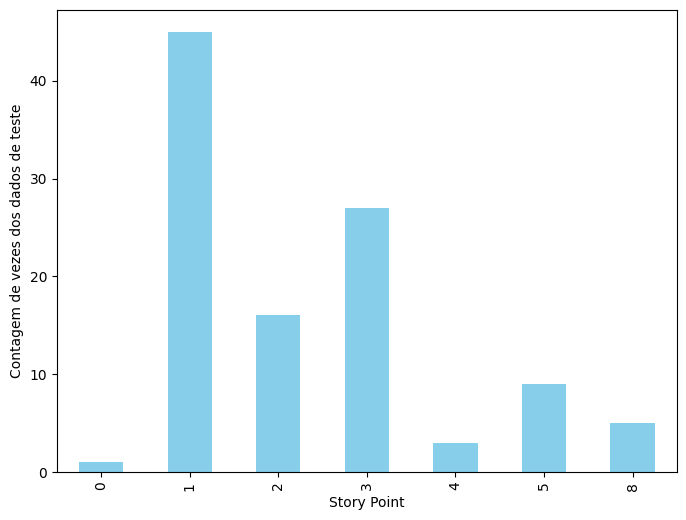

In [150]:
value_count = dados_teste["storypoints"].value_counts().sort_index()
plt.figure(figsize=(8,6))
value_count.plot(kind='bar', color='skyblue')
plt.ylabel("Value Counts dos Story Points")
plt.xlabel("Story Point")
plt.ylabel("Contagem de vezes dos dados de teste")

A variável preditora do modelo é somente texto. Portanto vamos extrair um bag-of-words para utilizar como atributo preditor.

# antes pré-processamento

In [151]:
df_clean.head()

,storypoints,context
0,1,Update templates for website merge requestsRel...
1,1,Make sure that we Capture Advanced Search in o...
2,1,Propose new IA for Brand and Digital Handbook#...
3,1,Cache `node_modules` for www-gitlab-com pipeli...
4,1,Disable all remaining unnecessary jobs in pipe...


In [152]:
# separação treino e teste
percent_treino = 0.7
num_linhas_treino = int(len(df_clean) * percent_treino)

dados_treino = df_clean.iloc[:num_linhas_treino]
dados_teste = df_clean.iloc[num_linhas_treino:]

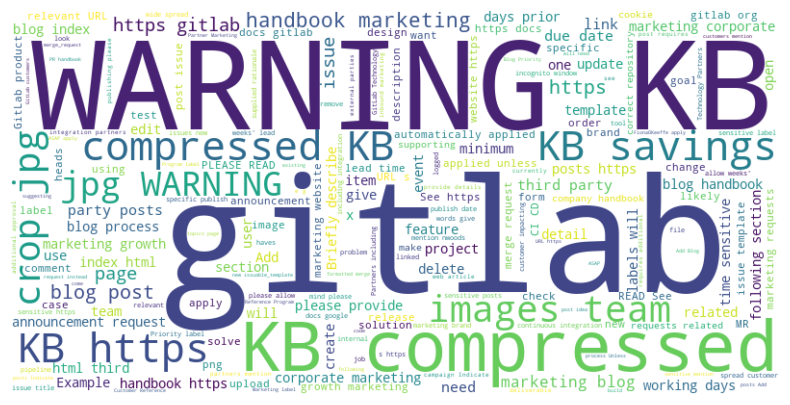

In [153]:
textos_concatenados = ' '.join(dados_treino['context'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(textos_concatenados)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## atributos bow

In [154]:

vec = CountVectorizer()
bow_treino = vec.fit_transform(dados_treino['context'])
bow_df_treino = pd.DataFrame(bow_treino.toarray(), columns=vec.get_feature_names_out())
bow_df_treino

,00,000,0014m00001h35gdqaq,01,02,02_at_09,03,032,03_at_13,03_at_14,...,zamirmartinsfilho,zeffmorgan,zegerjan,zhll9r1er7ilskpzriiff3,zj,zjx5qwyfbkc,zoom,zsuzsannakovacs,zzplok3lqqwzj5u7svzujvfa,zzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
243,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
244,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


O bow gerou 5102 colunas, com o pré-processamento isso irá diminuir.

In [155]:
bow_teste = vec.transform(dados_teste['context'])
bow_df_teste = pd.DataFrame(bow_teste.toarray(), columns=vec.get_feature_names_out())
bow_df_teste

,00,000,0014m00001h35gdqaq,01,02,02_at_09,03,032,03_at_13,03_at_14,...,zamirmartinsfilho,zeffmorgan,zegerjan,zhll9r1er7ilskpzriiff3,zj,zjx5qwyfbkc,zoom,zsuzsannakovacs,zzplok3lqqwzj5u7svzujvfa,zzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104,0,1,0,2,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# depois pre-processamento

In [156]:
# processamento do texto
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words("english"))

def remover_stopwords(texto):
  palavras = word_tokenize(texto)
  palavas_sem_stopwords = [palavra for palavra in palavras if palavra.lower() not in stop_words]
  return ' '.join(palavas_sem_stopwords)

def remover_urls(texto):
    return re.sub(r'http\S+|www\S+', ' ', texto)

def remover_html_tags(texto):
    return re.sub(r'<[^>]+>', ' ', texto)

def remover_palavras_com_numeros(texto):
    return re.sub(r'\b\w*\d\w*\b', ' ', texto)

def remover_pontuacoes(texto):
    return re.sub(r'[^\w\s]', ' ', texto)

def remover_caracteres_especiais(texto):
    return re.sub(r'[^A-Za-z0-9\s]', '', texto)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gigi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gigi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [157]:
# remover stopwords
df_clean["context"] = df_clean['context'].apply(remover_stopwords)
df_clean["context"] = df_clean['context'].apply(remover_urls)
df_clean["context"] = df_clean['context'].apply(remover_html_tags)
df_clean["context"] = df_clean['context'].apply(remover_palavras_com_numeros)
df_clean["context"] = df_clean['context'].apply(remover_pontuacoes)
df_clean["context"] = df_clean['context'].apply(remover_caracteres_especiais)
df_clean["context"] = df_clean["context"].str.replace(r'\s+', ' ', regex=True).str.strip()

C:\Users\gigi\AppData\Local\Temp\ipykernel_5868\2397164545.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["context"] = df_clean['context'].apply(remover_stopwords)
C:\Users\gigi\AppData\Local\Temp\ipykernel_5868\2397164545.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["context"] = df_clean['context'].apply(remover_urls)
C:\Users\gigi\AppData\Local\Temp\ipykernel_5868\2397164545.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [158]:
df_clean.head()

,storypoints,context
0,1,Update templates website merge requestsRelates...
1,1,Make sure Capture Advanced Search feature feat...
2,1,Propose new IA Brand Digital Handbook Goals Pr...
3,1,Cache nodemodules pipelines UPDATE NOTE MR imp...
4,1,Disable remaining unnecessary jobs pipeline me...


In [159]:
# separação treino e teste (após pré-processamento)
percent_treino = 0.7
num_linhas_treino = int(len(df_clean) * percent_treino)

dados_treino = df_clean.iloc[:num_linhas_treino]
dados_teste = df_clean.iloc[num_linhas_treino:]

## atributos bow

In [160]:
vec = CountVectorizer()
bow_treino = vec.fit_transform(dados_treino['context'])
bow_df_treino = pd.DataFrame(bow_treino.toarray(), columns=vec.get_feature_names_out())
bow_df_treino

,aakgun,aakritigupta,aaronfriel,aashish,aasimkhan,ab,abbreviation,abbreviations,abd,abilities,...,yxous,zacbadgleycopy,zachrice,zackcuddy,zamirmartinsfilho,zeffmorgan,zegerjan,zj,zoom,zsuzsannakovacs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
243,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
244,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Reduziu para 5028 colunas, depois da remoção das stopwords, com a remoção das urls para 4600

In [161]:
bow_teste = vec.transform(dados_teste['context'])
bow_df_teste = pd.DataFrame(bow_teste.toarray(), columns=vec.get_feature_names_out())
bow_df_teste

,aakgun,aakritigupta,aaronfriel,aashish,aasimkhan,ab,abbreviation,abbreviations,abd,abilities,...,yxous,zacbadgleycopy,zachrice,zackcuddy,zamirmartinsfilho,zeffmorgan,zegerjan,zj,zoom,zsuzsannakovacs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


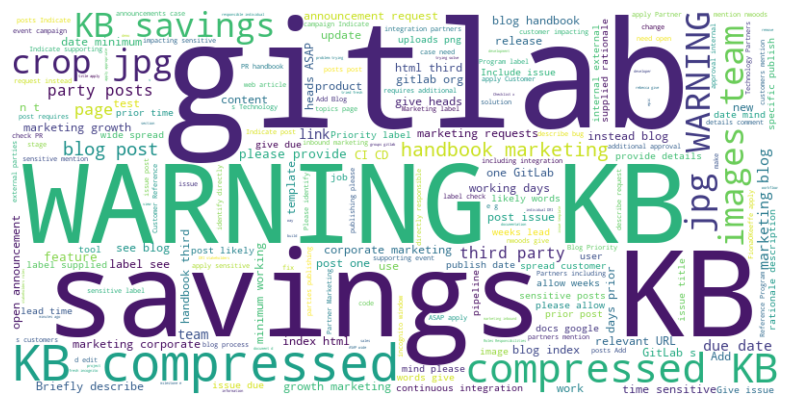

In [162]:
textos_concatenados = ' '.join(dados_treino['context'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(textos_concatenados)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# modelos

In [163]:
model = SVR(kernel='linear')
model.fit(bow_df_treino, dados_treino["storypoints"])
y_pred = model.predict(bow_df_teste)
mae_bow = mean_absolute_error(dados_teste["storypoints"], y_pred)
df_results = df_results.append({'modelo':'mae_bow', 'MAE Teste': mae_bow}, ignore_index=True)
df_results

C:\Users\gigi\AppData\Local\Temp\ipykernel_5868\2739833848.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'modelo':'mae_bow', 'MAE Teste': mae_bow}, ignore_index=True)


,modelo,MAE Teste
0,mae_media_sp,1.332011
1,mae_bow,1.551816


O MAE do teste para um modelo Bag-of-words é de 1.68, maior do que o MAE do teste quando usamos o Story Point Médio, de 1.35, portanto esse último modelo é um modelo pior que o baseline média selecionado.

Vamos testar um modelo com TF-IDF

# vetorização TF-IDF

In [164]:
vec = TfidfVectorizer(max_features=50)
tfidf_matrix_treino = vec.fit_transform(dados_treino["context"])
tfidf_matrix_teste = vec.transform(dados_teste["context"])

# Modelos SVM com TF-IDF

In [165]:
model = SVR(kernel='linear')
model.fit(tfidf_matrix_treino, dados_treino["storypoints"])
y_pred = model.predict(tfidf_matrix_teste)
mae_tfidf = mean_absolute_error(dados_teste["storypoints"], y_pred)
df_results = df_results.append({'modelo':'mae_tfidf', 'MAE Teste': mae_tfidf}, ignore_index=True)
df_results

C:\Users\gigi\AppData\Local\Temp\ipykernel_5868\1988293367.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'modelo':'mae_tfidf', 'MAE Teste': mae_tfidf}, ignore_index=True)


,modelo,MAE Teste
0,mae_media_sp,1.332011
1,mae_bow,1.551816
2,mae_tfidf,1.247787


<AxesSubplot: ylabel='modelo'>

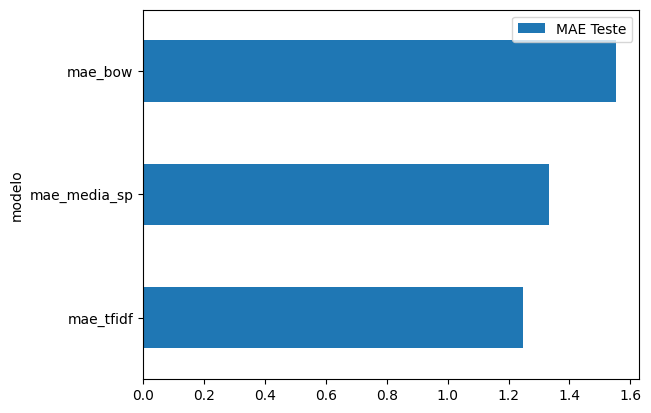

In [166]:
df_results = df_results.sort_values(by="MAE Teste")
df_results.plot.barh(y='MAE Teste', x ='modelo')

Um modelo com tfidf tem melhor capacidade que um modelo bow e que um modelo mae_medio_sp, pois tem um menor MAE.

# Modelo com legibilidade

In [167]:
df_full = pd.read_csv(filename)
df_full["context"] = df_full["title"] + df_full["description"]
df_full = df_full.drop(['created', 'issuekey', 'title', 'description'], axis=1)

# remoção outlier
mean = df_full["storypoints"].mean()
std_dev = df_full["storypoints"].std()
outlier_cutoff = 2 * std_dev
df_clean = df_full[(df_full["storypoints"] >= mean - outlier_cutoff) & (df_full["storypoints"] <= mean + outlier_cutoff)]

In [168]:
#colunas = ['gunning_fog', 'flesch_reading_ease', 'flesch_kincaid_grade', 'coleman_liau_index', 'automated_readability_index', 'linsear_write_formula', 'dale_chall_readability_score']
#colunas = ['gunning_fog', 'flesch_reading_ease', 'flesch_kincaid_grade', 'coleman_liau_index', 'automated_readability_index', 'linsear_write_formula', 'dale_chall_readability_score', 'polarity','subjectivity']
#colunas = ['polarity','subjectivity']
colunas = ['gunning_fog', 'polarity','subjectivity']
df_clean['gunning_fog'] = df_clean['context'].apply(textstat.gunning_fog)
df_clean['flesch_reading_ease'] = df_clean['context'].apply(textstat.flesch_reading_ease)
df_clean['flesch_kincaid_grade'] = df_clean['context'].apply(textstat.flesch_kincaid_grade)
df_clean['coleman_liau_index'] = df_clean['context'].apply(textstat.coleman_liau_index)
df_clean['automated_readability_index'] = df_clean['context'].apply(textstat.automated_readability_index)
df_clean['linsear_write_formula'] = df_clean['context'].apply(textstat.linsear_write_formula)
df_clean['dale_chall_readability_score'] = df_clean['context'].apply(textstat.dale_chall_readability_score)
df_clean['polarity'] = df_clean['context'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_clean['subjectivity'] = df_clean['context'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

C:\Users\gigi\AppData\Local\Temp\ipykernel_5868\2015135487.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['gunning_fog'] = df_clean['context'].apply(textstat.gunning_fog)
C:\Users\gigi\AppData\Local\Temp\ipykernel_5868\2015135487.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['flesch_reading_ease'] = df_clean['context'].apply(textstat.flesch_reading_ease)
C:\Users\gigi\AppData\Local\Temp\ipykernel_5868\2015135487.py:7: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [169]:
df_clean.head()

,storypoints,context,gunning_fog,flesch_reading_ease,flesch_kincaid_grade,coleman_liau_index,automated_readability_index,linsear_write_formula,dale_chall_readability_score,polarity,subjectivity
0,1,Update templates for website merge requestsRel...,8.85,41.77,10.6,19.30,19.2,8.500000,13.53,0.133333,0.966667
1,1,Make sure that we Capture Advanced Search in o...,7.19,33.81,11.5,19.42,18.2,7.071429,10.00,0.110714,0.366270
2,1,Propose new IA for Brand and Digital Handbook#...,17.34,24.71,17.1,20.20,25.3,16.250000,11.38,0.070350,0.372007
3,1,Cache `node_modules` for www-gitlab-com pipeli...,14.98,51.92,12.9,12.42,17.7,16.250000,10.49,0.086750,0.431778
4,1,Disable all remaining unnecessary jobs in pipe...,11.86,43.43,12.0,14.50,15.2,12.333333,10.04,-0.133333,0.766667


In [170]:
# separação entre treino e teste
dados_treino = df_clean.iloc[:num_linhas_treino]
dados_teste = df_clean.iloc[num_linhas_treino:]

In [171]:
model = SVR()
model.fit(dados_treino[colunas], dados_treino["storypoints"])
y_pred = model.predict(dados_teste[colunas])
mae_tfidf = mean_absolute_error(dados_teste["storypoints"], y_pred)
df_results = df_results.append({'modelo':'mae_legibility', 'MAE Teste': mae_tfidf}, ignore_index=True)
df_results

C:\Users\gigi\AppData\Local\Temp\ipykernel_5868\43689958.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({'modelo':'mae_legibility', 'MAE Teste': mae_tfidf}, ignore_index=True)


,modelo,MAE Teste
0,mae_tfidf,1.247787
1,mae_media_sp,1.332011
2,mae_bow,1.551816
3,mae_legibility,1.221740


In [1]:
plt.figure(figsize=(8, 6))
df_results = df_results.sort_values(by="MAE Teste")
df_results.plot.barh(y='MAE Teste', x ='modelo')

NameError: name 'plt' is not defined